# 🔬 SE Asia Tobacco Susceptibility — End-to-End ML Pipeline

**Target**: `Susceptibility` → binary classification (`susceptible` vs `non-susceptible`)  
**Data**: SE Asia survey dataset · 35,461 rows · 19 features  
**Class balance**: ~31% susceptible / ~69% non-susceptible → class-weight correction applied

### Sections
1. Environment & Reproducibility  
2. Data Ingestion & EDA  
3. Feature Engineering & Preprocessing  
4. Model Training & HPO (RandomizedSearchCV)  
5. Evaluation — CV Leaderboard, Curves, Permutation Importance  
6. Final Summary

## 1 · Environment & Reproducibility

In [2]:
import warnings, time
warnings.filterwarnings("ignore")

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import loguniform, randint

from sklearn.model_selection  import (train_test_split, StratifiedKFold,
                                       cross_validate, RandomizedSearchCV,
                                       learning_curve)
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.impute            import SimpleImputer
from sklearn.compose           import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, mutual_info_classif

from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble      import (RandomForestClassifier,
                                   GradientBoostingClassifier,
                                   ExtraTreesClassifier)
from sklearn.svm           import SVC
from sklearn.neighbors     import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                              classification_report, confusion_matrix,
                              RocCurveDisplay, PrecisionRecallDisplay,
                              ConfusionMatrixDisplay, average_precision_score,
                              balanced_accuracy_score)
from sklearn.inspection import permutation_importance

# ── Global config ──────────────────────────────────────────────────────────────
SEED       = 42
TEST_SIZE  = 0.20
CV_FOLDS   = 5
N_ITER_HPO = 40
DATA_PATH  = "/home/imran/Desktop/Nayeem/Youth-Tobacco-Survey/SE_Asia.csv"

np.random.seed(SEED)
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams.update({"figure.dpi":120, "axes.spines.top":False, "axes.spines.right":False})
print("✅  Environment ready")

✅  Environment ready


## 2 · Data Ingestion & EDA

### Feature legend (inferred from survey context)
| Column | Meaning |
|---|---|
| q9 | Age group (13 or below / 14 years / 15 or above) |
| q10 | Gender — **dropped** (near-constant: Male, 57% missing) |
| q11–q23 | Yes/No tobacco-related survey questions |
| q27 | Yes/No response |
| Country | Survey country (7 SE-Asian nations) |
| Year | Survey year (2013–2022) |
| Income Group | Country income classification |
| **Susceptibility** | **Target** — susceptible / non-susceptible |

In [3]:
# ── 2.1  Load ──────────────────────────────────────────────────────────────────
df = pd.read_csv(DATA_PATH)

# Drop near-constant / useless column
df.drop(columns=["q10"], inplace=True)

TARGET = "Susceptibility"
print(f"Shape      : {df.shape}")
print(f"Target dist:\n{df[TARGET].value_counts()}\n")
df.head(3)

Shape      : (35461, 19)
Target dist:
Susceptibility
non-susceptible    24559
susceptible        10902
Name: count, dtype: int64



,q9,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,Country,Year,Income Group,Susceptibility,q27
0,13 or below,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Bangladesh,2013,Lower middle income,non-susceptible,yes
1,13 or below,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Bangladesh,2013,Lower middle income,susceptible,yes
2,14 years,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Bangladesh,2013,Lower middle income,non-susceptible,yes


     missing  missing_% dtype  n_unique
q16    10314       29.1   str         2
q9       755        2.1   str         3
q14      457        1.3   str         2
q23      453        1.3   str         2
q22      455        1.3   str         2
q18      461        1.3   str         2
q19      436        1.2   str         2
q20      431        1.2   str         2
q17      391        1.1   str         2
q21      358        1.0   str         2
q13      355        1.0   str         2
q15      303        0.9   str         2
q11      268        0.8   str         2
q12      219        0.6   str         2


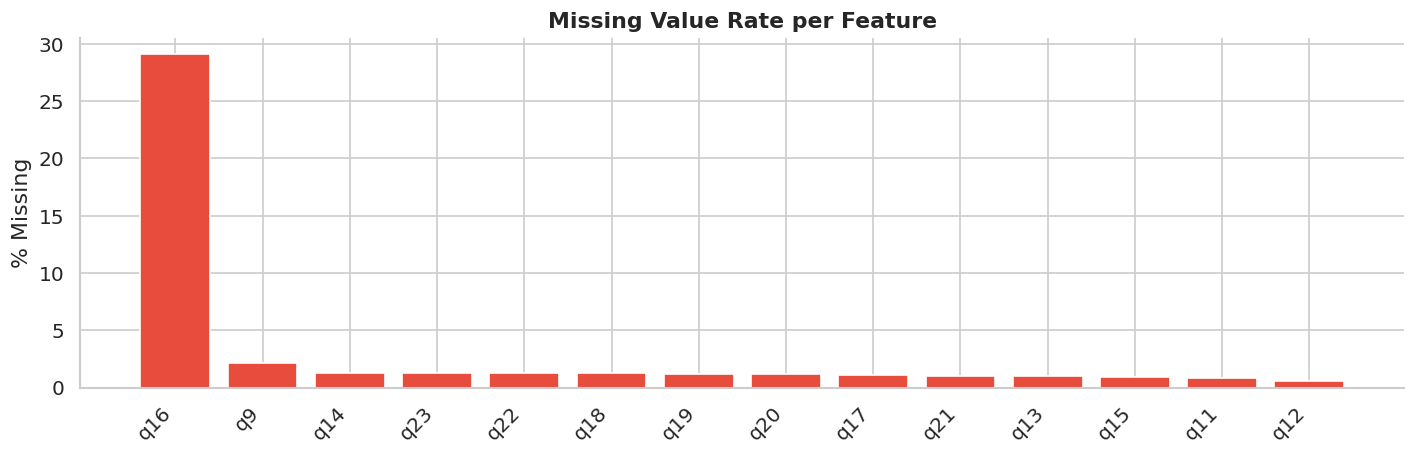

In [4]:
# ── 2.2  Missing value audit ───────────────────────────────────────────────────
miss = pd.DataFrame({
    "missing"   : df.isnull().sum(),
    "missing_%"  : (df.isnull().mean()*100).round(1),
    "dtype"     : df.dtypes,
    "n_unique"  : df.nunique(),
}).sort_values("missing_%", ascending=False)

print(miss[miss["missing"] > 0].to_string())

fig, ax = plt.subplots(figsize=(12,4))
miss_pct = miss[miss["missing"]>0]["missing_%"]
ax.bar(miss_pct.index, miss_pct.values, color="#e74c3c", edgecolor="white")
ax.set_ylabel("% Missing")
ax.set_title("Missing Value Rate per Feature", fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

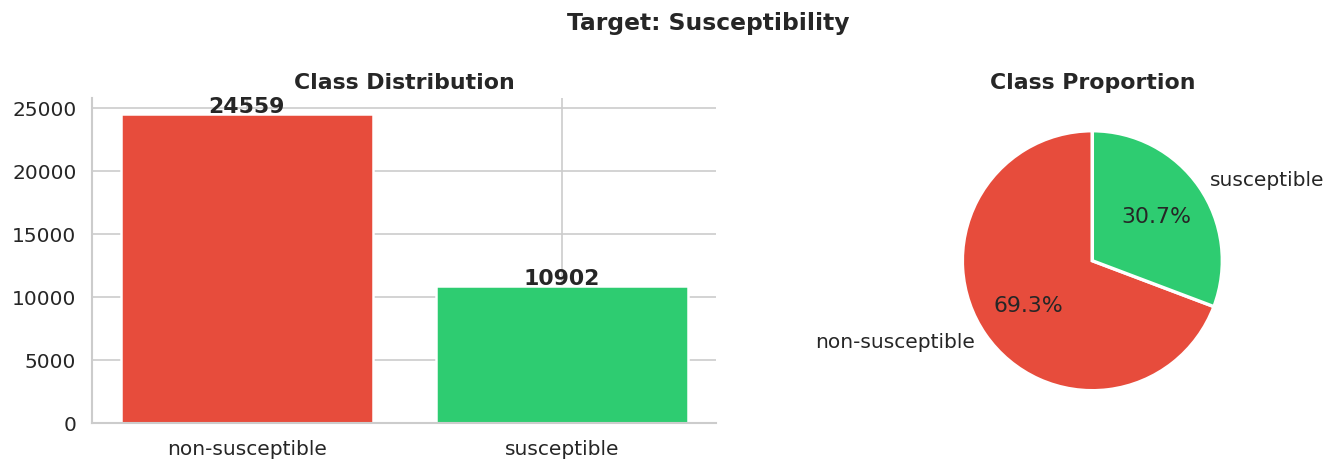

Imbalance ratio: 2.25  → class_weight='balanced' will be applied


In [5]:
# ── 2.3  Target distribution ───────────────────────────────────────────────────
fig, axes = plt.subplots(1,2, figsize=(12,4))

counts = df[TARGET].value_counts()
colors = ["#e74c3c","#2ecc71"]
axes[0].bar(counts.index, counts.values, color=colors, edgecolor="white", linewidth=1.5)
axes[0].set_title("Class Distribution", fontweight="bold")
for i,v in enumerate(counts.values):
    axes[0].text(i, v+120, str(v), ha="center", fontweight="bold")

axes[1].pie(counts.values, labels=counts.index, autopct="%1.1f%%",
            colors=colors, startangle=90, wedgeprops=dict(edgecolor="white",linewidth=2))
axes[1].set_title("Class Proportion", fontweight="bold")
plt.suptitle("Target: Susceptibility", fontsize=14, fontweight="bold")
plt.tight_layout(); plt.show()

ratio = counts.max()/counts.min()
print(f"Imbalance ratio: {ratio:.2f}  → class_weight='balanced' will be applied")

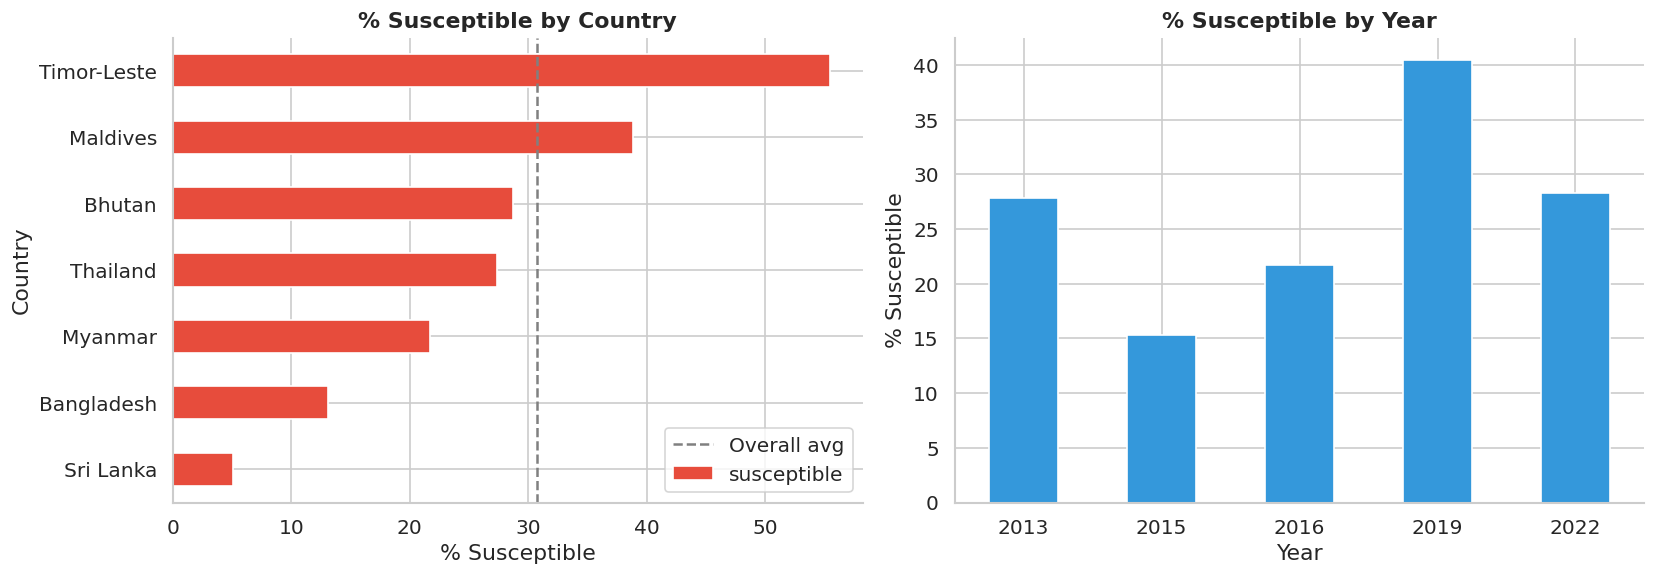

In [6]:
# ── 2.4  Susceptibility by Country & Year ─────────────────────────────────────
fig, axes = plt.subplots(1,2, figsize=(14,5))

ct_country = pd.crosstab(df["Country"], df[TARGET], normalize="index")*100
ct_country["susceptible"].sort_values().plot(
    kind="barh", ax=axes[0], color="#e74c3c", edgecolor="white")
axes[0].set_title("% Susceptible by Country", fontweight="bold")
axes[0].set_xlabel("% Susceptible")
axes[0].axvline(counts["susceptible"]/len(df)*100, ls="--", color="gray", lw=1.5, label="Overall avg")
axes[0].legend()

ct_year = pd.crosstab(df["Year"], df[TARGET], normalize="index")*100
ct_year["susceptible"].plot(
    kind="bar", ax=axes[1], color="#3498db", edgecolor="white")
axes[1].set_title("% Susceptible by Year", fontweight="bold")
axes[1].set_xlabel("Year"); axes[1].set_ylabel("% Susceptible")
plt.xticks(rotation=0)
plt.tight_layout(); plt.show()

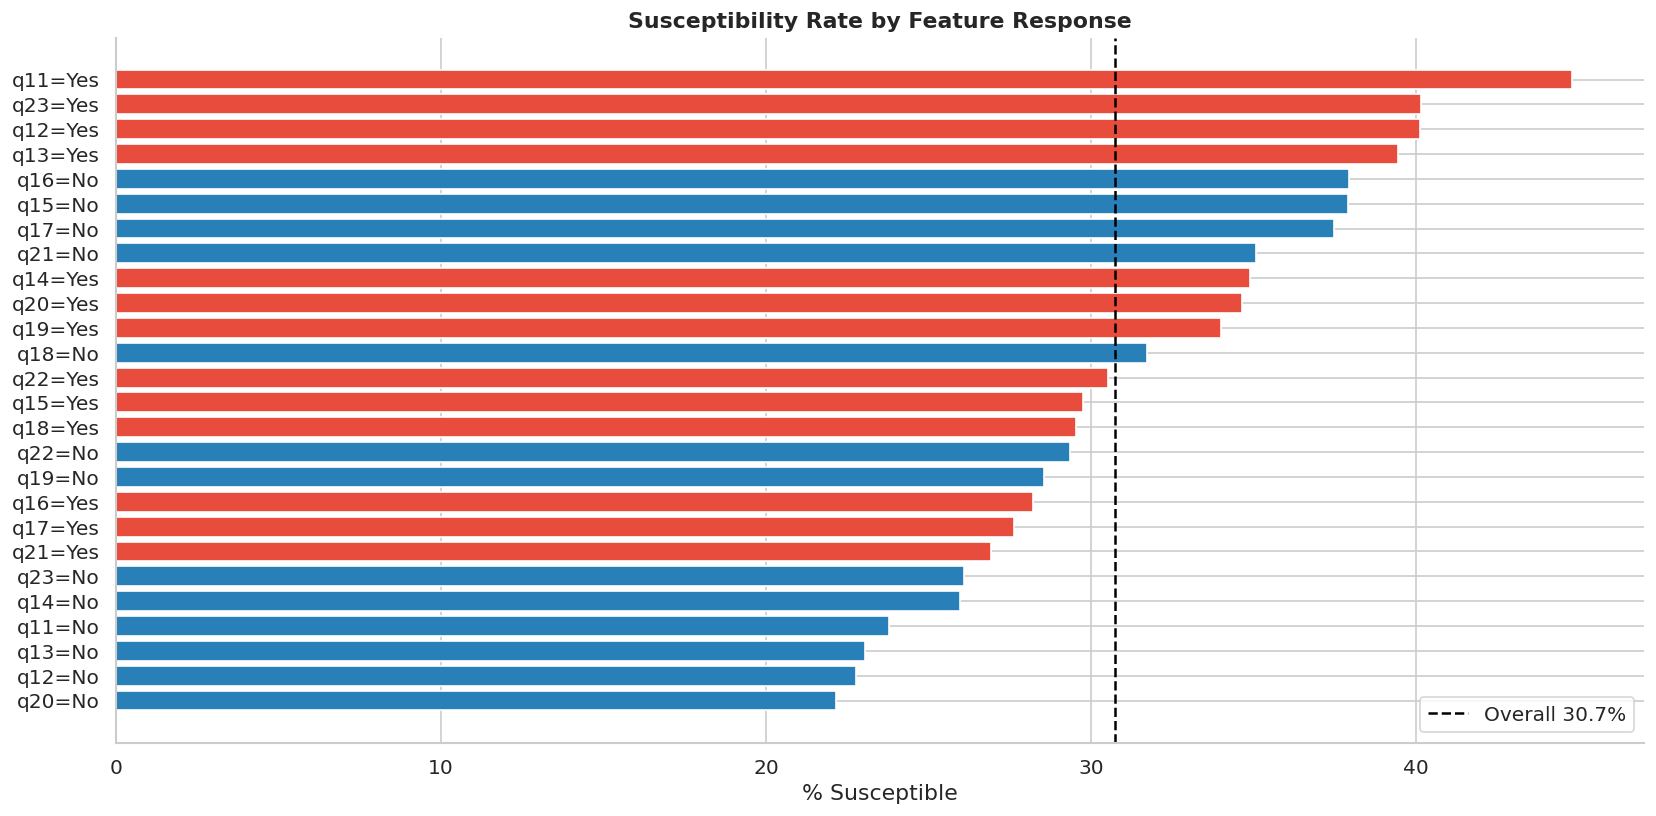

In [7]:
# ── 2.5  Yes/No question breakdown by susceptibility ──────────────────────────
yes_no_cols = [c for c in df.columns if df[c].dropna().isin(["Yes","No"]).all()
               and c != TARGET]
yes_no_cols += ["q27"] if "q27" in df.columns else []
yes_no_cols = list(dict.fromkeys(yes_no_cols))   # deduplicate

susc_rate = {}
for col in yes_no_cols:
    sub = df[[col, TARGET]].dropna()
    for val in ["Yes","No"]:
        key = f"{col}={val}"
        mask = sub[col]==val
        if mask.sum() > 0:
            susc_rate[key] = (sub.loc[mask, TARGET]=="susceptible").mean()*100

sr_df = pd.Series(susc_rate).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14,7))
colors_bar = ["#e74c3c" if "=Yes" in i else "#2980b9" for i in sr_df.index]
ax.barh(sr_df.index[::-1], sr_df.values[::-1], color=colors_bar[::-1], edgecolor="white")
ax.set_xlabel("% Susceptible")
ax.set_title("Susceptibility Rate by Feature Response", fontweight="bold")
overall_pct = (df[TARGET]=="susceptible").mean()*100
ax.axvline(overall_pct, ls="--", color="black", lw=1.5, label=f"Overall {overall_pct:.1f}%")
ax.legend()
plt.tight_layout(); plt.show()

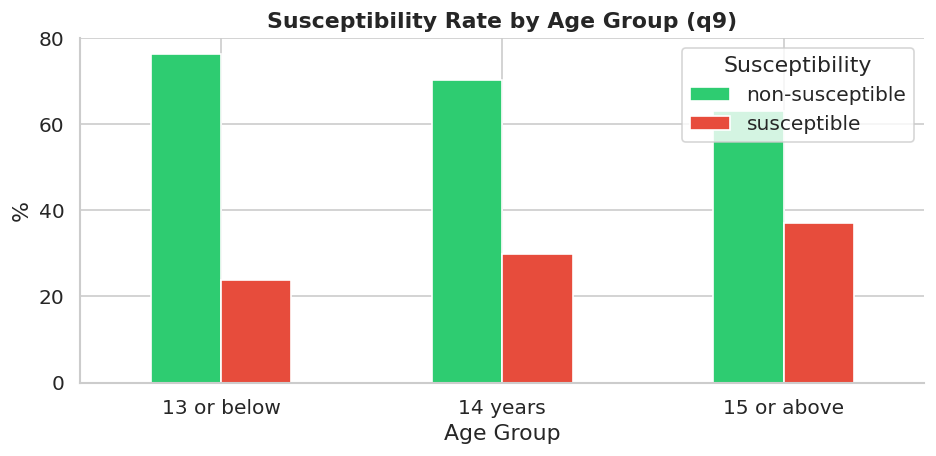

In [8]:
# ── 2.6  Age group vs Susceptibility ──────────────────────────────────────────
if "q9" in df.columns:
    ct_age = pd.crosstab(df["q9"], df[TARGET], normalize="index")*100
    fig, ax = plt.subplots(figsize=(8,4))
    ct_age.plot(kind="bar", ax=ax, color=["#2ecc71","#e74c3c"], edgecolor="white")
    ax.set_title("Susceptibility Rate by Age Group (q9)", fontweight="bold")
    ax.set_xlabel("Age Group"); ax.set_ylabel("%")
    plt.xticks(rotation=0); ax.legend(title="Susceptibility")
    plt.tight_layout(); plt.show()

In [9]:
# ── 2.7  Income Group vs Susceptibility ───────────────────────────────────────
ct_inc = pd.crosstab(df["Income Group"], df[TARGET], normalize="index")*100
print("Susceptibility rate by income group:")
print(ct_inc.round(1).to_string())

Susceptibility rate by income group:
Susceptibility       non-susceptible  susceptible
Income Group                                     
Lower middle income             69.6         30.4
Upper middle income             68.8         31.2


## 3 · Feature Engineering & Preprocessing

**Encoding strategy:**
- `q9` (age group) → Ordinal (ordered: 13-below < 14 years < 15-above)
- Yes/No columns → Binary (Yes=1, No=0)
- `q27` → Binary (yes=1, no=0)
- `Country`, `Income Group` → Ordinal encoding
- `Year` → kept as numeric

**Imputation:** most-frequent for all (survey data — no median makes sense for categoricals)  
**Scaling:** RobustScaler on all encoded features  
**Class imbalance:** `class_weight='balanced'` on all models

In [13]:
# ── 3.1  Feature definitions ────────────────────────────────────────────────────
TARGET = "Susceptibility"
X = df.drop(columns=[TARGET]).copy()
y = (df[TARGET] == "susceptible").astype(int)  # 1=susceptible, 0=non-susceptible

# Column groups
age_col     = ["q9"]
# ...existing code...
binary_cols = [
    c for c in X.columns
    if pd.Series(X[c].dropna().astype(str).str.lower()).isin(["yes", "no"]).all()
]
# ...existing code...
binary_cols += ["q27"] if "q27" in X.columns else []
binary_cols  = list(dict.fromkeys(binary_cols))

cat_cols    = ["Country", "Income Group"]
num_cols    = ["Year"]

print(f"Age ordinal : {age_col}")
print(f"Binary (Y/N): {binary_cols}")
print(f"Categorical : {cat_cols}")
print(f"Numeric     : {num_cols}")
print(f"\nTarget: 1=susceptible ({y.mean()*100:.1f}%)  0=non-susceptible ({(1-y).mean()*100:.1f}%)")

Age ordinal : ['q9']
Binary (Y/N): ['q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q27']
Categorical : ['Country', 'Income Group']
Numeric     : ['Year']

Target: 1=susceptible (30.7%)  0=non-susceptible (69.3%)


In [14]:
# ── 3.2  Train / test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

print(f"Train: {X_train.shape}  susceptible: {y_train.mean()*100:.1f}%")
print(f"Test : {X_test.shape}   susceptible: {y_test.mean()*100:.1f}%")

Train: (28368, 18)  susceptible: 30.7%
Test : (7093, 18)   susceptible: 30.7%


In [15]:
# ── 3.3  Preprocessing pipelines ───────────────────────────────────────────────
# Age: ordinal encoder with explicit ordering
age_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        categories=[["13 or below","14 years","15 or above"]],
        handle_unknown="use_encoded_value", unknown_value=-1)),
    ("scaler",  RobustScaler()),
])

# Yes/No: map to 0/1 first, then impute
class BinaryMapper:
    """Maps Yes->1 / No->0 (case-insensitive) before sklearn steps."""
    def fit(self, X, y=None): return self
    def transform(self, X):
        return (pd.DataFrame(X)
                  .apply(lambda c: c.str.lower().map({"yes":1,"no":0}))
                  .values)

from sklearn.base import BaseEstimator, TransformerMixin
class BinaryMapTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df_tmp = pd.DataFrame(X)
        return df_tmp.apply(lambda c: c.astype(str).str.lower()
                                         .map({"yes":1,"no":0,"1":1,"0":0})).values.astype(float)

binary_pipe = Pipeline([
    ("mapper",  BinaryMapTransformer()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler",  RobustScaler()),
])

# Categorical: ordinal + impute
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

# Numeric: impute + scale
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler()),
])

preprocessor = ColumnTransformer([
    ("age",    age_pipe,    age_col),
    ("binary", binary_pipe, binary_cols),
    ("cat",    cat_pipe,    cat_cols),
    ("num",    num_pipe,    num_cols),
], remainder="drop")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Feature names after transform
feat_names = (age_col + binary_cols + cat_cols + num_cols)
print(f"Preprocessed shape: {X_train_prep.shape}")
print(f"Feature names ({len(feat_names)}): {feat_names}")

Preprocessed shape: (28368, 18)
Feature names (18): ['q9', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q27', 'Country', 'Income Group', 'Year']


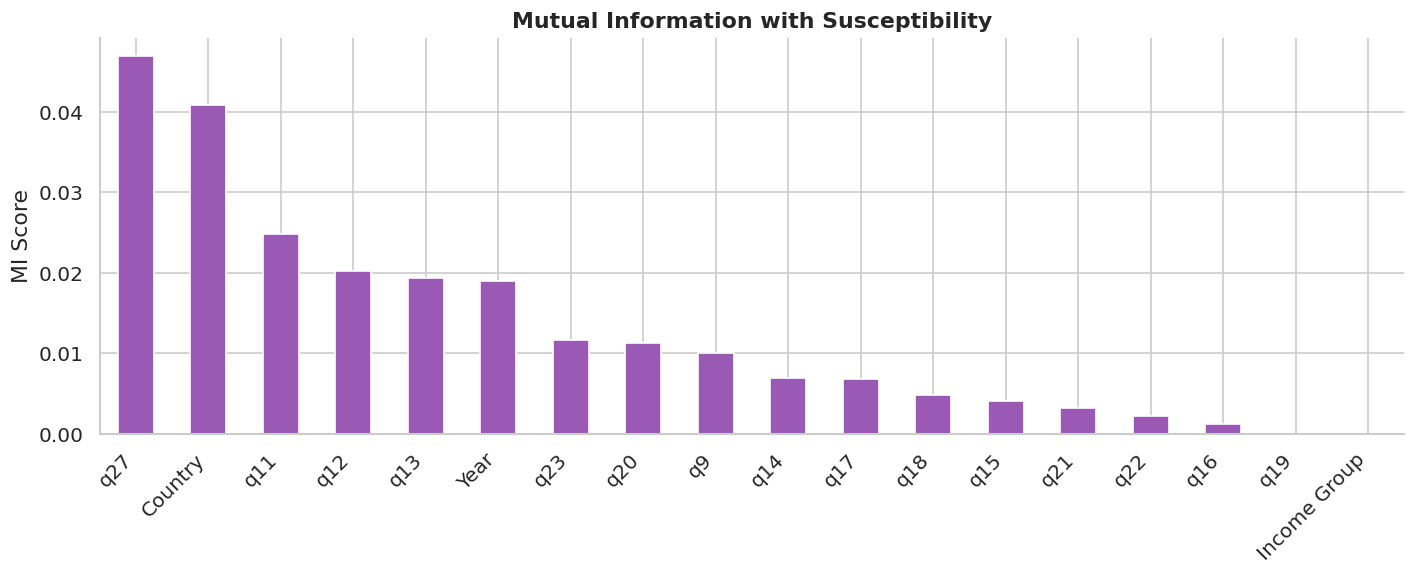

Top 10 predictive features (MI):
q27        0.046850
Country    0.040881
q11        0.024879
q12        0.020184
q13        0.019373
Year       0.018972
q23        0.011610
q20        0.011332
q9         0.010063
q14        0.006900


In [16]:
# ── 3.4  Mutual Information ────────────────────────────────────────────────────
mi = mutual_info_classif(X_train_prep, y_train, random_state=SEED)
mi_series = pd.Series(mi, index=feat_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12,5))
mi_series.plot(kind="bar", ax=ax, color="#9b59b6", edgecolor="white")
ax.set_title("Mutual Information with Susceptibility", fontweight="bold")
ax.set_ylabel("MI Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

print("Top 10 predictive features (MI):")
print(mi_series.head(10).to_string())

Features selected: 8 / 18
Selected: ['q9', 'q14', 'q19', 'q21', 'q22', 'q27', 'Country', 'Year']


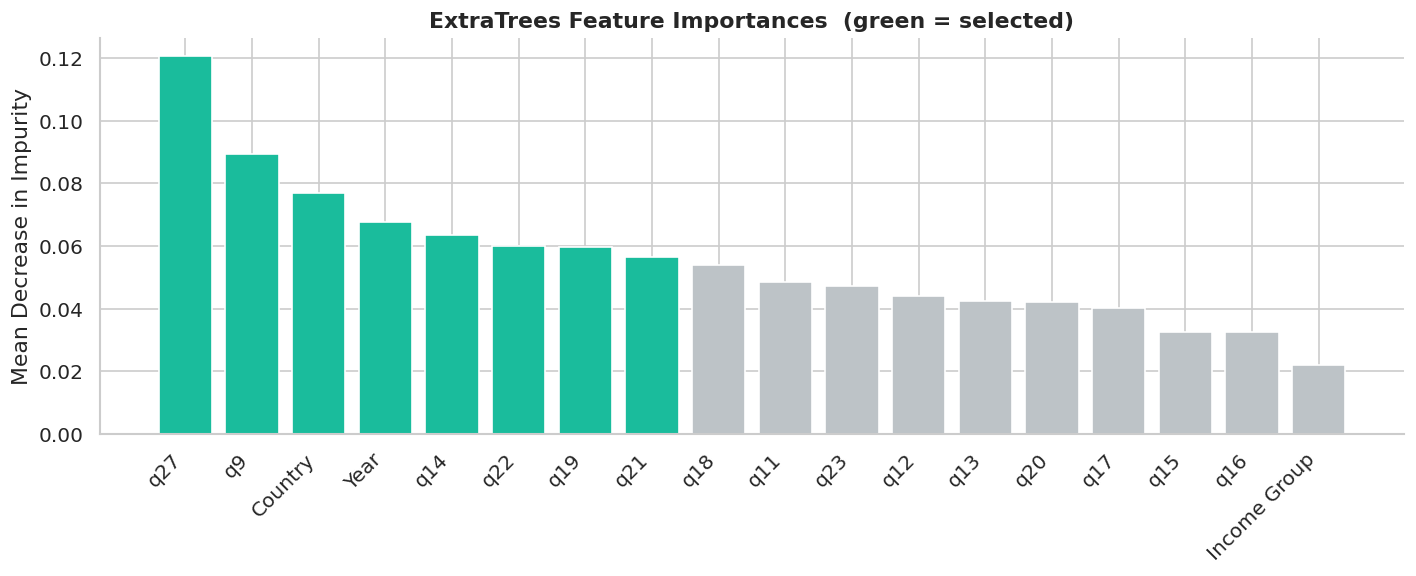

In [17]:
# ── 3.5  ExtraTrees feature selection ─────────────────────────────────────────
selector = SelectFromModel(
    ExtraTreesClassifier(n_estimators=300, class_weight="balanced", random_state=SEED),
    threshold="mean"
)
selector.fit(X_train_prep, y_train)

X_train_sel = selector.transform(X_train_prep)
X_test_sel  = selector.transform(X_test_prep)

kept_mask  = selector.get_support()
kept_names = [n for n, k in zip(feat_names, kept_mask) if k]
print(f"Features selected: {len(kept_names)} / {len(feat_names)}")
print(f"Selected: {kept_names}")

# Plot importances
importances = selector.estimator_.feature_importances_
imp_df = (pd.DataFrame({"feature":feat_names,"importance":importances})
            .sort_values("importance", ascending=False))

fig, ax = plt.subplots(figsize=(12,5))
ax.bar(imp_df["feature"], imp_df["importance"], 
       color=["#1abc9c" if k else "#bdc3c7" for k in kept_mask[np.argsort(importances)[::-1]]],
       edgecolor="white")
ax.set_title("ExtraTrees Feature Importances  (green = selected)", fontweight="bold")
ax.set_ylabel("Mean Decrease in Impurity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

## 4 · Model Training & Hyperparameter Optimisation

Five classifiers with `class_weight='balanced'` (to handle ~31/69 imbalance).  
HPO via **RandomizedSearchCV** — 40 iterations × 5-fold stratified CV, scoring = **ROC-AUC**.

In [18]:
SEARCH_SPACES = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=3000, class_weight="balanced", random_state=SEED),
        "params": {
            "C"      : loguniform(1e-3, 1e3),
            "penalty": ["l2"],
            "solver" : ["lbfgs", "saga"],
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=SEED, n_jobs=-1),
        "params": {
            "n_estimators"    : randint(100, 500),
            "max_depth"       : [None, 5, 10, 20, 30],
            "min_samples_split": randint(2, 20),
            "max_features"    : ["sqrt", "log2", 0.5],
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=SEED),
        "params": {
            "n_estimators" : randint(100, 400),
            "learning_rate": loguniform(0.01, 0.3),
            "max_depth"    : randint(2, 8),
            "subsample"    : [0.7, 0.8, 0.9, 1.0],
        }
    },
    "ExtraTrees": {
        "model": ExtraTreesClassifier(class_weight="balanced", random_state=SEED, n_jobs=-1),
        "params": {
            "n_estimators"    : randint(100, 500),
            "max_features"    : ["sqrt", "log2", 0.5, 0.8],
            "min_samples_leaf": randint(1, 15),
        }
    },
    "SVM": {
        "model": SVC(probability=True, class_weight="balanced", random_state=SEED),
        "params": {
            "C"     : loguniform(0.1, 100),
            "kernel": ["rbf", "linear"],
            "gamma" : ["scale", "auto"],
        }
    },
}

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
print(f"HPO config: {N_ITER_HPO} iterations × {CV_FOLDS}-fold CV  |  scoring=roc_auc")

HPO config: 40 iterations × 5-fold CV  |  scoring=roc_auc


In [19]:
hpo_results = {}

for name, cfg in SEARCH_SPACES.items():
    t0 = time.time()
    search = RandomizedSearchCV(
        cfg["model"], cfg["params"],
        n_iter=N_ITER_HPO, cv=cv,
        scoring="roc_auc", refit=True,
        random_state=SEED, n_jobs=-1, verbose=0
    )
    search.fit(X_train_sel, y_train)
    elapsed = time.time() - t0

    hpo_results[name] = {
        "search"    : search,
        "best_model": search.best_estimator_,
        "best_params": search.best_params_,
        "cv_roc_auc": search.best_score_,
        "elapsed_s" : elapsed,
    }
    print(f"  {name:<22}  CV ROC-AUC = {search.best_score_:.4f}  ({elapsed:.1f}s)")

print("\n✅  HPO complete")

  LogisticRegression      CV ROC-AUC = 0.7211  (2.0s)


/home/imran/Desktop/Nayeem/Youth-Tobacco-Survey/ml_venv/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/imran/Desktop/Nayeem/Youth-Tobacco-Survey/ml_venv/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/imran/Desktop/Nayeem/Youth-Tobacco-Survey/ml_venv/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib 

  RandomForest            CV ROC-AUC = 0.7487  (26.6s)
  GradientBoosting        CV ROC-AUC = 0.7544  (37.6s)
  ExtraTrees              CV ROC-AUC = 0.7477  (33.9s)
  SVM                     CV ROC-AUC = 0.7323  (1063.9s)

✅  HPO complete


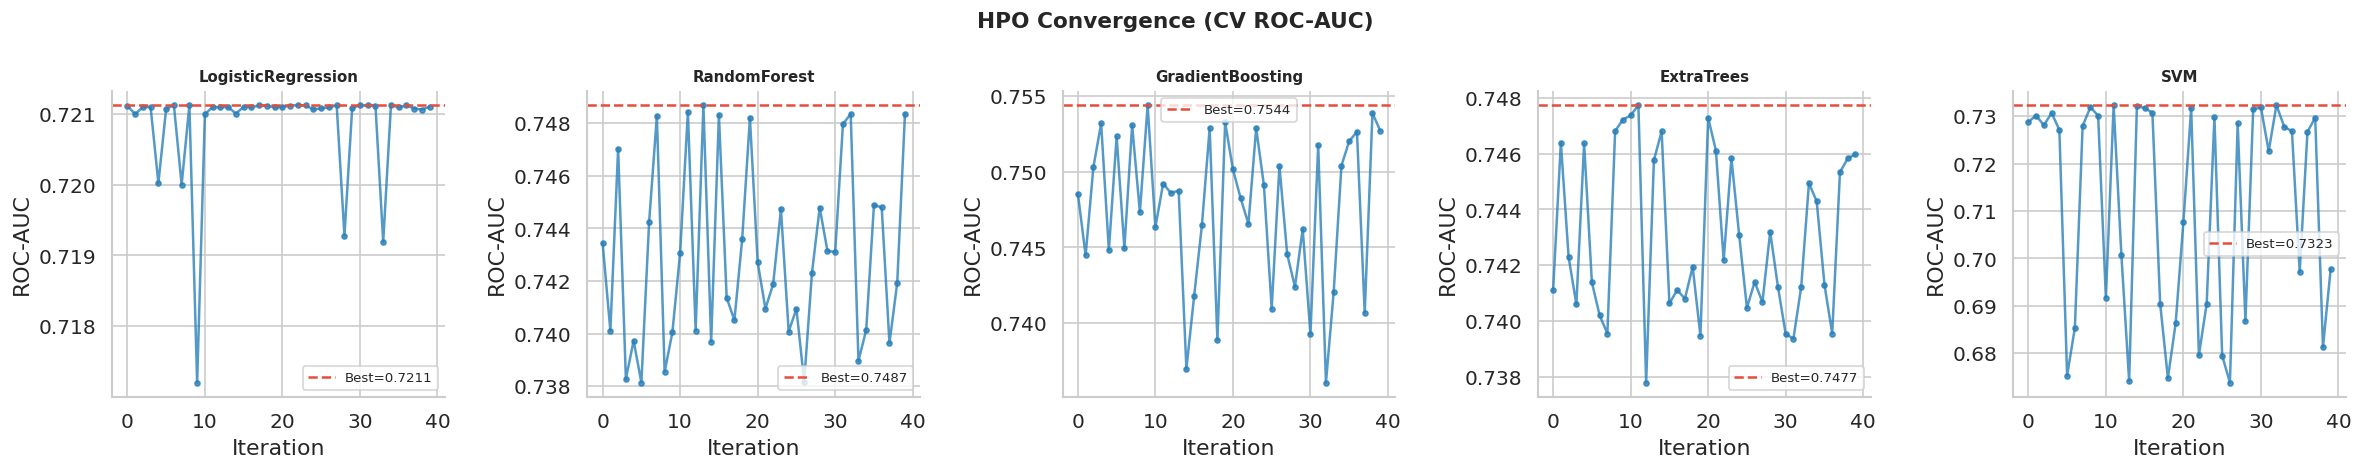

In [20]:
# ── HPO convergence ────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(hpo_results), figsize=(20,4), sharey=False)
for ax, (name, res) in zip(axes, hpo_results.items()):
    cv_df = pd.DataFrame(res["search"].cv_results_)
    ax.plot(cv_df["mean_test_score"], "o-", ms=3, lw=1.5, color="#2980b9", alpha=0.8)
    ax.axhline(res["cv_roc_auc"], color="#e74c3c", ls="--", lw=1.5,
               label=f"Best={res['cv_roc_auc']:.4f}")
    ax.set_title(name, fontsize=9, fontweight="bold")
    ax.set_xlabel("Iteration"); ax.set_ylabel("ROC-AUC"); ax.legend(fontsize=8)
fig.suptitle("HPO Convergence (CV ROC-AUC)", fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()

## 5 · Evaluation

### 5.1  CV Leaderboard  
### 5.2  Test-set metrics  
### 5.3  Confusion matrices  
### 5.4  ROC & Precision-Recall curves  
### 5.5  Learning curves  
### 5.6  Permutation importance

In [21]:
# ── 5.1  CV leaderboard ────────────────────────────────────────────────────────
records = []
for name, res in hpo_results.items():
    cv_out = cross_validate(
        res["best_model"], X_train_sel, y_train, cv=cv,
        scoring=["roc_auc","f1","balanced_accuracy"], n_jobs=-1
    )
    records.append({
        "Model"            : name,
        "CV ROC-AUC"       : f"{cv_out['test_roc_auc'].mean():.4f} ± {cv_out['test_roc_auc'].std():.4f}",
        "CV F1"            : f"{cv_out['test_f1'].mean():.4f} ± {cv_out['test_f1'].std():.4f}",
        "CV Balanced-Acc"  : f"{cv_out['test_balanced_accuracy'].mean():.4f} ± {cv_out['test_balanced_accuracy'].std():.4f}",
        "HPO (s)"          : f"{res['elapsed_s']:.1f}",
    })
    res["cv_out"] = cv_out

leaderboard = pd.DataFrame(records).sort_values("CV ROC-AUC", ascending=False)
leaderboard.index = range(1, len(leaderboard)+1)
print("="*90)
print("Cross-Validated Leaderboard  (scoring on imbalanced target → ROC-AUC & Balanced-Acc)")
print("="*90)
print(leaderboard.to_string())

Cross-Validated Leaderboard  (scoring on imbalanced target → ROC-AUC & Balanced-Acc)
                Model       CV ROC-AUC            CV F1  CV Balanced-Acc HPO (s)
1    GradientBoosting  0.7544 ± 0.0054  0.4838 ± 0.0115  0.6430 ± 0.0054    37.6
2        RandomForest  0.7487 ± 0.0053  0.5752 ± 0.0063  0.6887 ± 0.0052    26.6
3          ExtraTrees  0.7477 ± 0.0058  0.5763 ± 0.0080  0.6888 ± 0.0067    33.9
4                 SVM  0.7323 ± 0.0075  0.5777 ± 0.0088  0.6898 ± 0.0077  1063.9
5  LogisticRegression  0.7211 ± 0.0058  0.5503 ± 0.0107  0.6673 ± 0.0088     2.0


In [22]:
# ── 5.2  Test-set metrics ─────────────────────────────────────────────────────
test_records = []
for name, res in hpo_results.items():
    m = res["best_model"]
    yp    = m.predict(X_test_sel)
    yprob = m.predict_proba(X_test_sel)[:,1]
    test_records.append({
        "Model"           : name,
        "Accuracy"        : round(accuracy_score(y_test, yp), 4),
        "Balanced-Acc"    : round(balanced_accuracy_score(y_test, yp), 4),
        "F1 (susceptible)": round(f1_score(y_test, yp), 4),
        "ROC-AUC"         : round(roc_auc_score(y_test, yprob), 4),
        "Avg-Precision"   : round(average_precision_score(y_test, yprob), 4),
    })

test_df = pd.DataFrame(test_records).sort_values("ROC-AUC", ascending=False)
test_df.index = range(1, len(test_df)+1)
print(test_df.to_string())

best_name  = test_df.iloc[0]["Model"]
best_model = hpo_results[best_name]["best_model"]
print(f"\n🏆  Best model: {best_name}")

                Model  Accuracy  Balanced-Acc  F1 (susceptible)  ROC-AUC  Avg-Precision
1    GradientBoosting    0.7351        0.6460            0.4904   0.7494         0.5684
2        RandomForest    0.6886        0.6866            0.5736   0.7456         0.5591
3          ExtraTrees    0.6841        0.6855            0.5729   0.7453         0.5601
4                 SVM    0.6818        0.6854            0.5731   0.7316         0.5348
5  LogisticRegression    0.6731        0.6686            0.5527   0.7167         0.5080

🏆  Best model: GradientBoosting


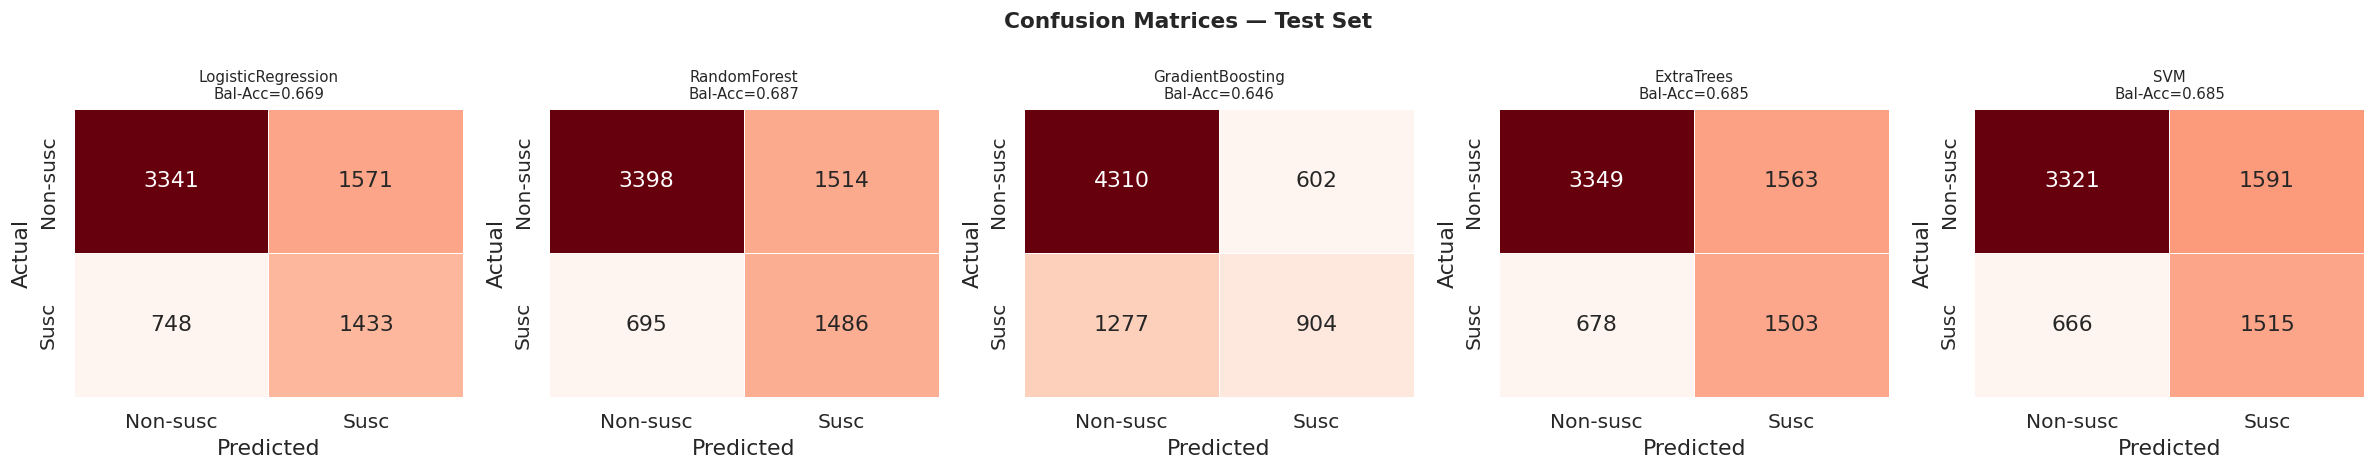

In [23]:
# ── 5.3  Confusion matrices ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(hpo_results), figsize=(20,4))
for ax, (name, res) in zip(axes, hpo_results.items()):
    yp = res["best_model"].predict(X_test_sel)
    cm = confusion_matrix(y_test, yp)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", ax=ax,
                xticklabels=["Non-susc","Susc"],
                yticklabels=["Non-susc","Susc"],
                cbar=False, linewidths=0.5)
    balacc = balanced_accuracy_score(y_test, yp)
    ax.set_title(f"{name}\nBal-Acc={balacc:.3f}", fontsize=9)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
fig.suptitle("Confusion Matrices — Test Set", fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()

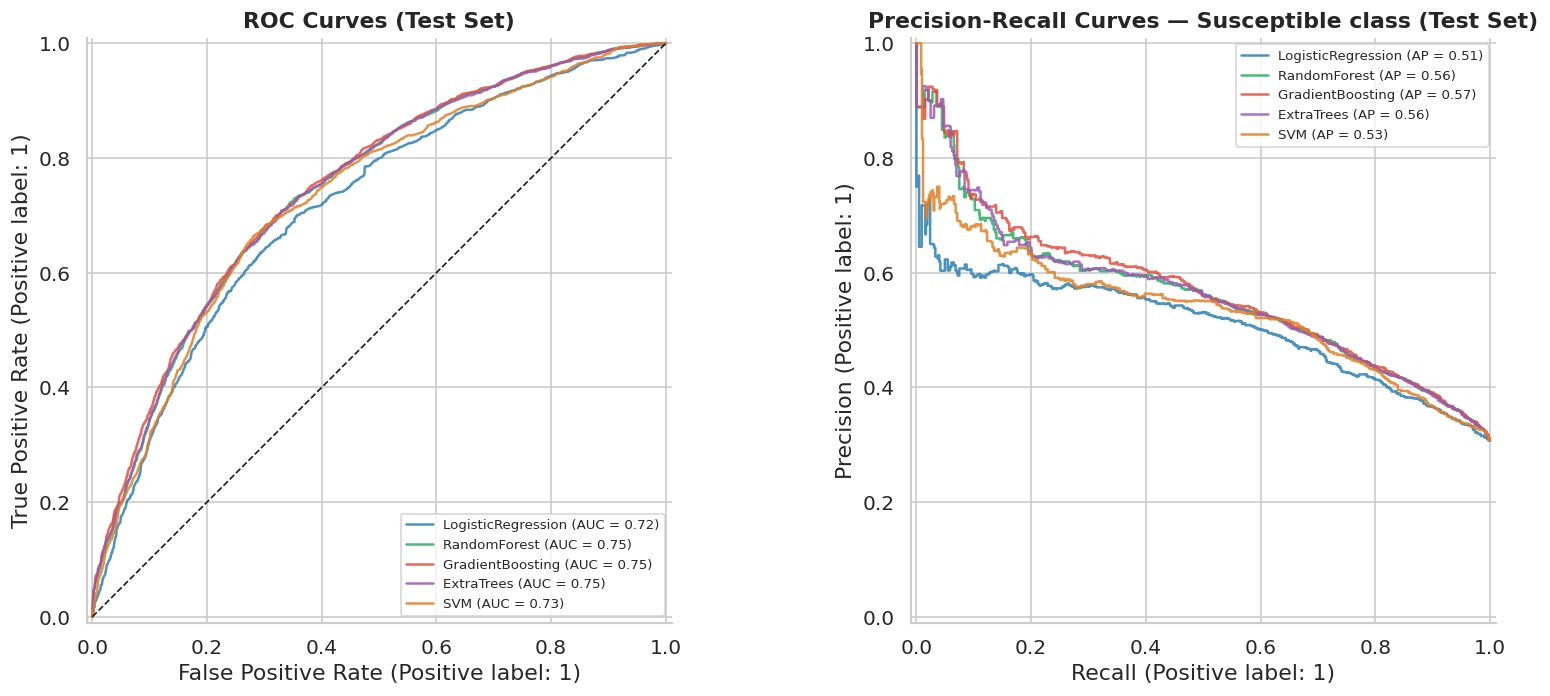

In [24]:
# ── 5.4  ROC & Precision-Recall curves ────────────────────────────────────────
fig, axes = plt.subplots(1,2, figsize=(14,6))
colors = ["#2980b9","#27ae60","#e74c3c","#9b59b6","#e67e22"]

for (name, res), color in zip(hpo_results.items(), colors):
    yprob = res["best_model"].predict_proba(X_test_sel)[:,1]
    RocCurveDisplay.from_predictions(
        y_test, yprob, name=name, ax=axes[0], color=color, alpha=0.85)
    PrecisionRecallDisplay.from_predictions(
        y_test, yprob, name=name, ax=axes[1], color=color, alpha=0.85)

axes[0].plot([0,1],[0,1],"k--",lw=1)
axes[0].set_title("ROC Curves (Test Set)", fontweight="bold")
axes[1].set_title("Precision-Recall Curves — Susceptible class (Test Set)", fontweight="bold")
axes[0].legend(loc="lower right", fontsize=8)
axes[1].legend(loc="upper right", fontsize=8)
plt.tight_layout(); plt.show()

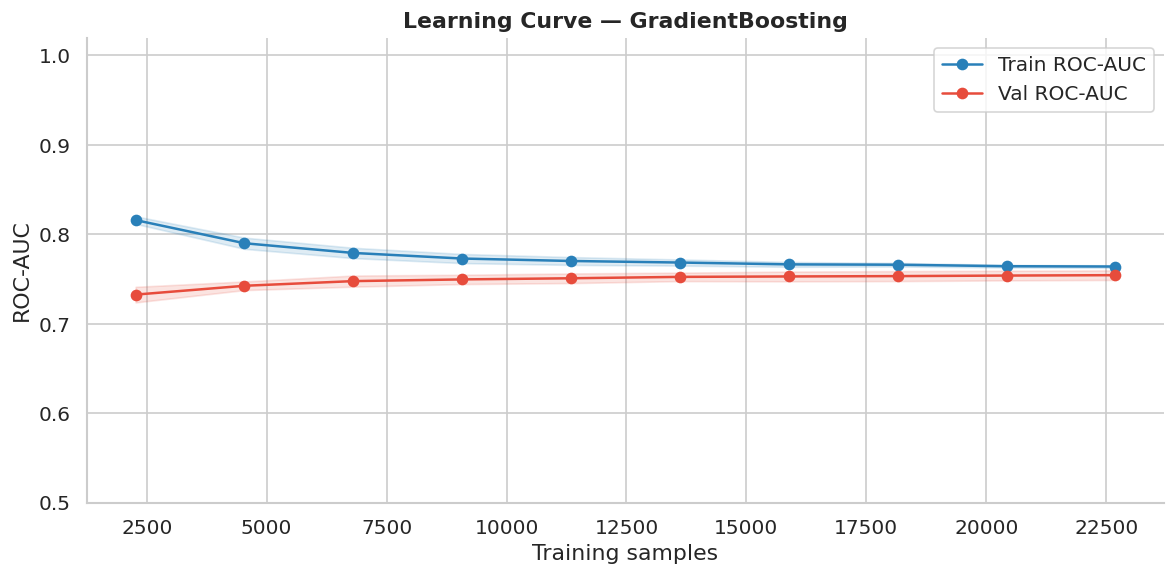

Train-Val gap at full data: 0.0097  → ✅ well-generalised


In [25]:
# ── 5.5  Learning curves (best model) ─────────────────────────────────────────
train_sizes, train_sc, val_sc = learning_curve(
    best_model, X_train_sel, y_train,
    cv=cv, scoring="roc_auc",
    train_sizes=np.linspace(0.1,1.0,10),
    n_jobs=-1, shuffle=True, random_state=SEED
)

fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(train_sizes, train_sc.mean(1)-train_sc.std(1),
                              train_sc.mean(1)+train_sc.std(1), alpha=0.15, color="#2980b9")
ax.fill_between(train_sizes, val_sc.mean(1)-val_sc.std(1),
                              val_sc.mean(1)+val_sc.std(1),   alpha=0.15, color="#e74c3c")
ax.plot(train_sizes, train_sc.mean(1), "o-", color="#2980b9", label="Train ROC-AUC")
ax.plot(train_sizes, val_sc.mean(1),   "o-", color="#e74c3c", label="Val ROC-AUC")
ax.set_xlabel("Training samples"); ax.set_ylabel("ROC-AUC")
ax.set_title(f"Learning Curve — {best_name}", fontweight="bold")
ax.legend(); ax.set_ylim(0.5, 1.02)
plt.tight_layout(); plt.show()

gap = train_sc.mean(1)[-1] - val_sc.mean(1)[-1]
print(f"Train-Val gap at full data: {gap:.4f}  → {'⚠ slight overfit' if gap>0.03 else '✅ well-generalised'}")

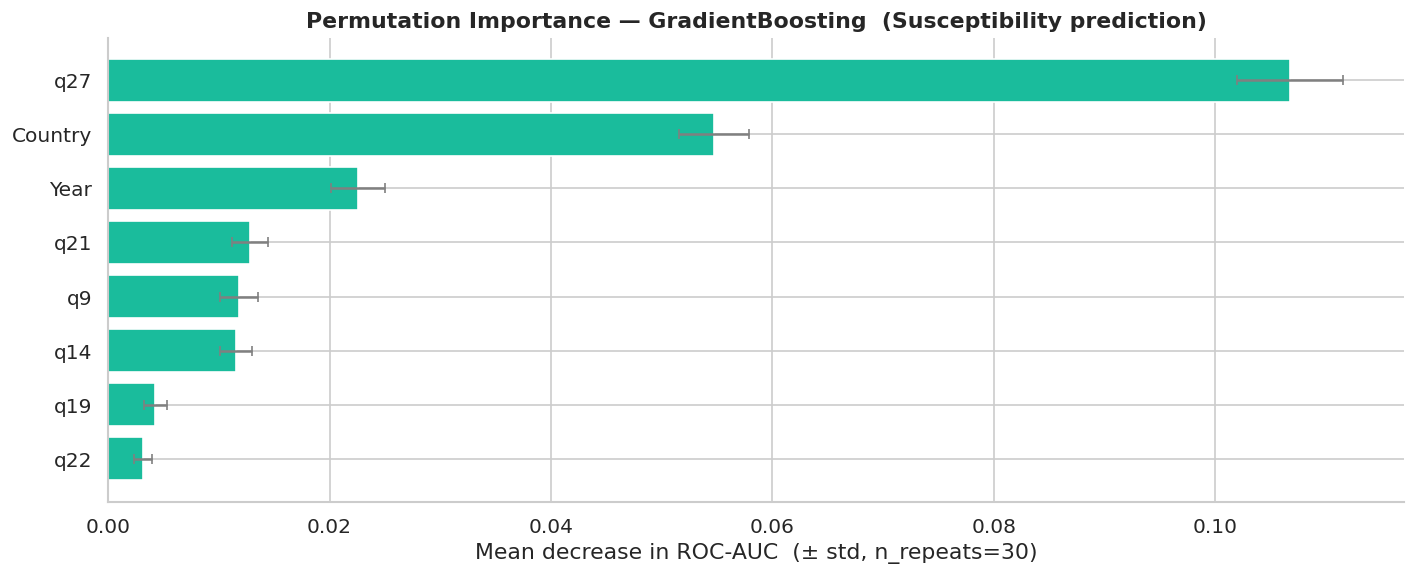

Top drivers of susceptibility prediction:
feature     mean      std
    q27 0.106725 0.004775
Country 0.054706 0.003175
   Year 0.022567 0.002417
    q21 0.012791 0.001615
     q9 0.011804 0.001704
    q14 0.011568 0.001431
    q19 0.004270 0.001031
    q22 0.003158 0.000775


In [26]:
# ── 5.6  Permutation importance (best model) ──────────────────────────────────
perm = permutation_importance(
    best_model, X_test_sel, y_test,
    n_repeats=30, random_state=SEED,
    scoring="roc_auc", n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": kept_names,
    "mean"   : perm.importances_mean,
    "std"    : perm.importances_std,
}).sort_values("mean", ascending=False)

fig, ax = plt.subplots(figsize=(12,5))
ax.barh(perm_df["feature"][::-1], perm_df["mean"][::-1],
        xerr=perm_df["std"][::-1], color="#1abc9c", edgecolor="white",
        error_kw=dict(ecolor="gray", capsize=3))
ax.set_xlabel("Mean decrease in ROC-AUC  (± std, n_repeats=30)")
ax.set_title(f"Permutation Importance — {best_name}  (Susceptibility prediction)", fontweight="bold")
plt.tight_layout(); plt.show()

print("Top drivers of susceptibility prediction:")
print(perm_df.head(8)[["feature","mean","std"]].to_string(index=False))

In [27]:
# ── 5.7  Classification report (best model) ───────────────────────────────────
yp    = best_model.predict(X_test_sel)
yprob = best_model.predict_proba(X_test_sel)[:,1]
print(f"Classification Report — {best_name}")
print("="*55)
print(classification_report(y_test, yp,
      target_names=["non-susceptible","susceptible"]))

Classification Report — GradientBoosting
                 precision    recall  f1-score   support

non-susceptible       0.77      0.88      0.82      4912
    susceptible       0.60      0.41      0.49      2181

       accuracy                           0.74      7093
      macro avg       0.69      0.65      0.66      7093
   weighted avg       0.72      0.74      0.72      7093



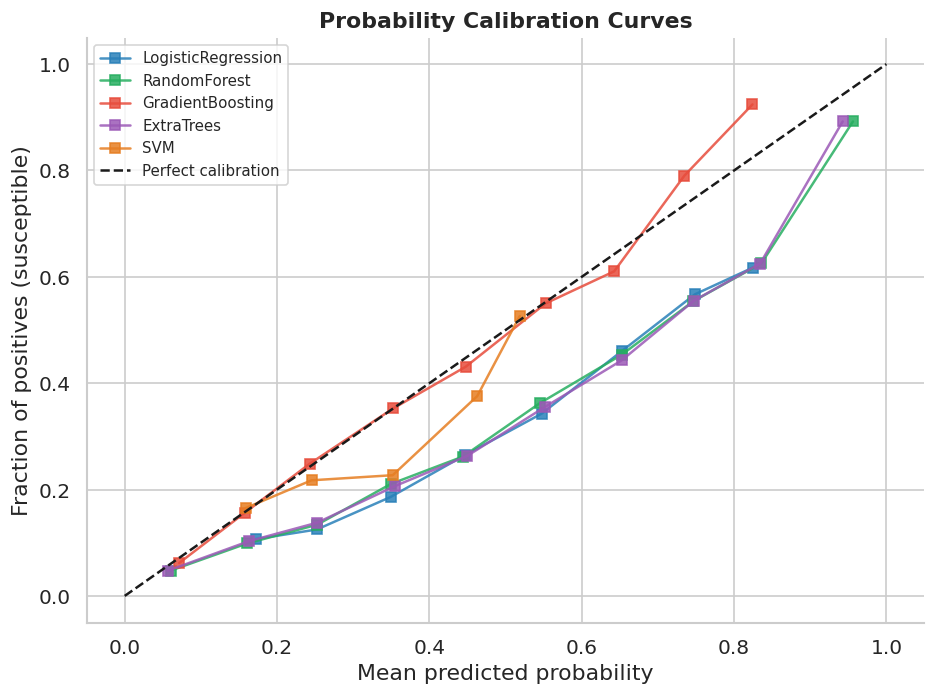

In [28]:
# ── 5.8  Probability calibration check ────────────────────────────────────────
from sklearn.calibration import calibration_curve

fig, ax = plt.subplots(figsize=(8,6))
colors2 = ["#2980b9","#27ae60","#e74c3c","#9b59b6","#e67e22"]
for (name, res), color in zip(hpo_results.items(), colors2):
    prob_pos = res["best_model"].predict_proba(X_test_sel)[:,1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    ax.plot(mean_pred, frac_pos, "s-", label=name, color=color, alpha=0.85)

ax.plot([0,1],[0,1],"k--",lw=1.5, label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives (susceptible)")
ax.set_title("Probability Calibration Curves", fontweight="bold")
ax.legend(fontsize=9)
plt.tight_layout(); plt.show()

## 6 · Final Model Summary

In [29]:
yp    = best_model.predict(X_test_sel)
yprob = best_model.predict_proba(X_test_sel)[:,1]

summary = {
    "Dataset"              : "SE_Asia.csv",
    "Task"                 : "Susceptibility prediction (binary)",
    "Samples (total)"      : len(df),
    "Train / Test"         : f"{len(X_train)} / {len(X_test)}",
    "Class balance"        : f"{(y==1).mean()*100:.1f}% susceptible",
    "Features (raw)"       : X.shape[1],
    "Features (selected)"  : X_train_sel.shape[1],
    "Best Model"           : best_name,
    "Test Accuracy"        : f"{accuracy_score(y_test, yp):.4f}",
    "Test Balanced-Acc"    : f"{balanced_accuracy_score(y_test, yp):.4f}",
    "Test F1 (susceptible)": f"{f1_score(y_test, yp):.4f}",
    "Test ROC-AUC"         : f"{roc_auc_score(y_test, yprob):.4f}",
    "Test Avg-Precision"   : f"{average_precision_score(y_test, yprob):.4f}",
    "CV Folds"             : CV_FOLDS,
    "HPO Iterations"       : N_ITER_HPO,
}

print("╔══════════════════════════════════════════════════════════════╗")
print("║          FINAL PIPELINE SUMMARY — SE Asia Susceptibility    ║")
print("╠══════════════════════════════════════════════════════════════╣")
for k, v in summary.items():
    print(f"║  {k:<30}: {str(v):<28} ║")
print("╚══════════════════════════════════════════════════════════════╝")

print("\nBest hyperparameters:")
for k, v in hpo_results[best_name]["best_params"].items():
    print(f"  {k}: {v}")

print("\nTop predictive features (permutation importance):")
print(perm_df.head(5)[["feature","mean"]].to_string(index=False))

╔══════════════════════════════════════════════════════════════╗
║          FINAL PIPELINE SUMMARY — SE Asia Susceptibility    ║
╠══════════════════════════════════════════════════════════════╣
║  Dataset                       : SE_Asia.csv                  ║
║  Task                          : Susceptibility prediction (binary) ║
║  Samples (total)               : 35461                        ║
║  Train / Test                  : 28368 / 7093                 ║
║  Class balance                 : 30.7% susceptible            ║
║  Features (raw)                : 18                           ║
║  Features (selected)           : 8                            ║
║  Best Model                    : GradientBoosting             ║
║  Test Accuracy                 : 0.7351                       ║
║  Test Balanced-Acc             : 0.6460                       ║
║  Test F1 (susceptible)         : 0.4904                       ║
║  Test ROC-AUC                  : 0.7494                       ║
║  Test 

---
### Pipeline Checklist

| Step | Detail | Status |
|---|---|---|
| Data ingestion | SE_Asia.csv (35,461 rows) | ✅ |
| Drop constant column | q10 (gender, near-constant) | ✅ |
| Missing value audit | q10 57%, q16 29% handled | ✅ |
| EDA — target balance | 31% susceptible — imbalanced | ✅ |
| EDA — by Country & Year | Susceptibility rate visualised | ✅ |
| EDA — feature breakdown | Yes/No response vs susceptibility | ✅ |
| Custom binary encoding | Yes→1 / No→0 for all q-cols | ✅ |
| Ordinal age encoding | 13≤ < 14 < 15+ | ✅ |
| RobustScaler | Outlier-resistant scaling | ✅ |
| class_weight='balanced' | All models — corrects 31/69 imbalance | ✅ |
| Mutual information | Feature relevance ranked | ✅ |
| ExtraTrees feature selection | SelectFromModel (mean threshold) | ✅ |
| 5-model HPO | RandomizedSearchCV, 40 iter | ✅ |
| CV leaderboard | ROC-AUC, F1, Balanced-Accuracy | ✅ |
| Confusion matrices | All 5 models | ✅ |
| ROC + PR curves | All models overlaid | ✅ |
| Learning curves | Bias-variance analysis | ✅ |
| Permutation importance | 30 repeats, named features | ✅ |
| Calibration curves | Probability reliability check | ✅ |